In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


h = 0.67
ρ_c0= 1.9e-26 * (h**2) #kgm^-3  
Ω_r0 = 9.4e-5
Ω_m0 = 0.32
ρ_r0 = Ω_r0 * ρ_c0
ρ_m0 = Ω_m0 * ρ_c0
H_0 = np.sqrt((8 * π * G * ρ_c0)/3)




# Define event functions to detect turnaround points
def event_y_max(t, y, *args):
    return y[1]  # Detect velocity = 0 (turnaround)
event_y_max.terminal = False  
event_y_max.direction = -1  # Detect peak (expansion slowing down)

def event_y_min(t, y, *args):
    return y[1]  # Detect velocity = 0
event_y_min.terminal = True   # Stop at turnaround
event_y_min.direction = 1     # Detect minimum (collapse starts)




def a(t): # as per RD
    return np.sqrt(2 * H_0 * t)

def V_shell(r_inner, r_outer):
    return (4 * π / 3) * (r_outer**3 - r_inner**3)


    

def rho_DM(t):
    return 0.85 * ρ_m0 * (a(t)**-3)  



def rho_background(r, t):
    return rho_DM(t) * (4/3) * np.pi * (r**3) 



def fdm_EOM(t, y, j):
    r, v = y 
    #print(delta_M[0])
    M_enclosed_total = M_pbh #+  np.sum(delta_M[:j+1])  
    dv_G_dt = -(G * M_enclosed_total)/(r**2)  # G.P.due to PBH only
    dv_QP_dt = QP_arr[j] 
    H_t = 1/(2*t)  # with H(t) = 1/2t in RD
    dv_H_dt = -(H_t*v)  #-ri_arr[j]/(4 * (t**2)) 
    return [v, dv_G_dt + dv_QP_dt + dv_H_dt ]




In [2]:
# The first check I would do is to set up the initial conditions
# (define the lists r_j and Delta M_j ) and then calculate the density
# at each point (rho_j) and check that it comes out constant 
# (which is should initially if you’ve set the initial conditions correctly).



t_i = 1e-22
t_f = 1e-2 
t_arr = np.geomspace(t_i, t_f, 100000)  


ri_arr = np.geomspace(1e-8, 1e-4, 7)  



rho_arr = np.zeros(len(ri_arr) - 1)
delta_M_arr = np.zeros(len(ri_arr))
for j in range(len(ri_arr) - 1): 
    if j == 0:
        delta_M_arr[j] = rho_DM(t_i) * V_shell(0, ri_arr[j]) 
        rho_arr[j] = rho_DM(t_i)
    else:
        delta_M_arr[j] = rho_DM(t_i) * V_shell(ri_arr[j-1], ri_arr[j])  
        V_j = V_shell(ri_arr[j-1], ri_arr[j])  
        rho_arr[j] = delta_M_arr[j] / V_j  
delta_M_arr[-1] = rho_DM(t_i) * V_shell(ri_arr[-2], ri_arr[-1])  


print("delta_M_arr = " , delta_M_arr, "m")
print("rho_arr =", rho_arr, "kg m⁻³")


delta_M_arr =  [1.06513583e+09 1.05448447e+11 1.05448447e+13 1.05448447e+15
 1.05448447e+17 1.05448447e+19 1.05448447e+21] m
rho_arr = [2.54282448e+32 2.54282448e+32 2.54282448e+32 2.54282448e+32
 2.54282448e+32 2.54282448e+32] kg m⁻³


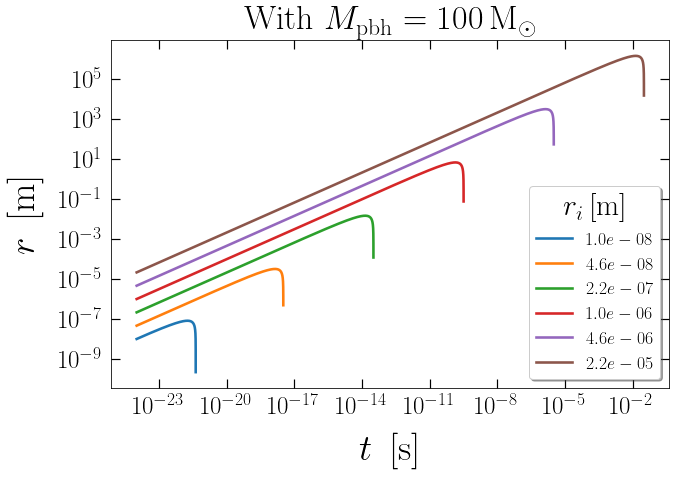

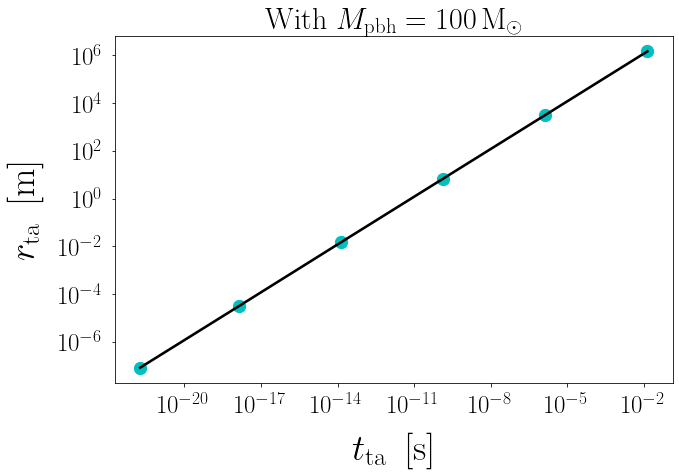

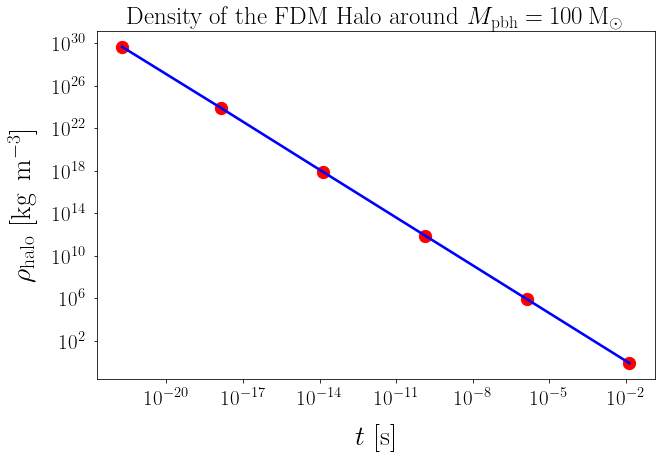

In [3]:
#you only compute the density once, at the start of the simulation.
# However, the density changes and needs to be recomputed.


def a(t):
    return np.sqrt(2 * H_0 * t)


def rho_DM(t):
    return 0.85 * (ρ_m0 * (a(t)**-3))  


def delta_M_dynamic(j, t):
    if j == 0:
        return rho_DM(t) * V_shell(0, ri_arr[j]) 
    else:
        return rho_DM(t) * V_shell(ri_arr[j-1], ri_arr[j])

    


def QP_function(rho_arr, ri_arr):
    grad_rho = np.gradient(rho_arr, ri_arr[:-1])  
    laplacian_rho = (1 / ri_arr[:-1]**2) * np.gradient(ri_arr[:-1]**2 * grad_rho, ri_arr[:-1])

    QP_arr = np.zeros_like(rho_arr)
    for j in range(len(rho_arr)):
        if rho_arr[j] > 0:
            QP_arr[j] = ((4 * m_FDM**2)/ hbar**2) * (rho_arr[j] * laplacian_rho[j] - 0.5 * ((grad_rho[j]**2) / rho_arr[j]))
        else:
            QP_arr[j] = 0  
    return QP_arr




def fdm_EOM_dynamic(t, y, j):
    r, v = y
    rho_arr = np.zeros(len(ri_arr) - 1)
    delta_M_arr = np.zeros(len(ri_arr))
    for j in range(len(ri_arr) - 1):
        if j == 0:
            delta_M_arr[j] = rho_DM(t) * V_shell(0, ri_arr[j]) 
            rho_arr[j] = delta_M_arr[j] / V_shell(0, ri_arr[j])  
        else:
            delta_M_arr[j] = rho_DM(t) * V_shell(ri_arr[j-1], ri_arr[j])  
            V_j = V_shell(ri_arr[j-1], ri_arr[j])  
            rho_arr[j] = delta_M_arr[j] / V_j  
    #print(rho_arr)
    
    QP_arr = QP_function(rho_arr, ri_arr)
    M_enclosed_total = M_pbh #+ np.sum([delta_M_dynamic(k, t) for k in range(j+1)])  
    dv_G_dt = -(G * M_enclosed_total) / (r**2)  
    dv_QP_dt = QP_arr[j]  
    H_t = 1 / (2 * t)  
    dv_H_dt = -(H_t * v)  
    return [v, dv_G_dt + dv_QP_dt + dv_H_dt]






M_pbh = 100 * M_solar 
r_ta_arr = []
t_ta_arr = []
t_i = 1e-24
t_f = 1
t_arr = np.geomspace(t_i, t_f, 100000)  
ri_arr = np.geomspace(1e-8, 1e-4, 7)  



fig, ax1 = plt.subplots(figsize=(10, 6.4))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for j in range(len(ri_arr) - 1):  
    r0 = [ri_arr[j], ri_arr[j]/(2 * t_i)] 
    sol = solve_ivp(fdm_EOM_dynamic, [t_i, t_f], r0, t_eval=t_arr, method='RK45', args=(j,),
                    events=[event_y_max, event_y_min], atol=1e-5, rtol=1e-5)
    ax1.loglog(sol.t, sol.y[0], label=f"${ri_arr[j]:.1e}$", color=colors[j])
    if len(sol.t_events[0]) > 0: 
        t_ta_arr.append(sol.t_events[0][0])
        r_ta_arr.append(sol.y_events[0][0][0])
ax1.tick_params(axis='x', pad=7.9)
ax1.tick_params(axis='y', pad=7.9)
plt.xlabel('$t \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r\,$ [m]',fontsize= 37, labelpad = 15)
plt.legend(prop = {'size':17.8}, loc = 'lower right',
           shadow = True, title = '$r_{i} \, [\mathrm{m}]$' ,title_fontsize = 30,
           facecolor = 'white',fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 34, pad = 8)
plt.savefig('fdmshells3.pdf', bbox_inches = 'tight')
plt.show()





# Plot turnaround radius vs turnaround time
fig, ax2 = plt.subplots(figsize=(10, 6.4))
ax2.scatter(t_ta_arr, r_ta_arr, color='c', s=150)
ax2.loglog(t_ta_arr, r_ta_arr,  color='k')
ax2.tick_params(axis='x', pad=7.9)
ax2.tick_params(axis='y', pad=7.9)
plt.xlabel('$t_\mathrm{ta} \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r_\mathrm{ta}\,$ [m]',fontsize= 37, labelpad = 15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 30, pad = 8)
plt.savefig('rta_vs_t.pdf', bbox_inches = 'tight')
plt.show()


rho_halo_arr = np.zeros(len(t_ta_arr))   
for i in range(len(r_ta_arr)):
    N_shells = i + 1  
    M_halo = np.sum(delta_M_arr[:N_shells])  
    V_outer = (4 / 3) * np.pi * (r_ta_arr[i]**3)  
    rho_halo_arr[i] = M_halo / V_outer  


fig, ax3 = plt.subplots(figsize=(10, 6.4))
ax3.scatter(t_ta_arr, rho_halo_arr, color='r', s=150)
ax3.loglog(t_ta_arr, rho_halo_arr,  color='b')
ax3.tick_params(axis='x', pad=7.9)
ax3.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t$ [s]', fontsize=28, labelpad = 15)
plt.ylabel(r'$\rho_{\mathrm{halo}}$ [kg\, m$^{-3}$]', fontsize=28, labelpad = 15)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_t.pdf', bbox_inches = 'tight')
plt.show()

In [4]:
def delta_M_dynamic(j, t):
    if j == 0:
        return rho_DM(t) * V_shell(0, ri_arr[j]) 
    else:
        return rho_DM(t) * V_shell(ri_arr[j-1], ri_arr[j])

    


def QP_function(rho_arr, ri_arr):
    grad_rho = np.gradient(rho_arr, ri_arr[:-1])  
    laplacian_rho = (1 / ri_arr[:-1]**2) * np.gradient(ri_arr[:-1]**2 * grad_rho, ri_arr[:-1])

    QP_arr = np.zeros_like(rho_arr)
    for j in range(len(rho_arr)):
        if rho_arr[j] > 0:
            QP_arr[j] = ((4 * m_FDM**2)/ hbar**2) * (rho_arr[j] * laplacian_rho[j] - 0.5 * ((grad_rho[j]**2) / rho_arr[j]))
        else:
            QP_arr[j] = 0  
    return QP_arr



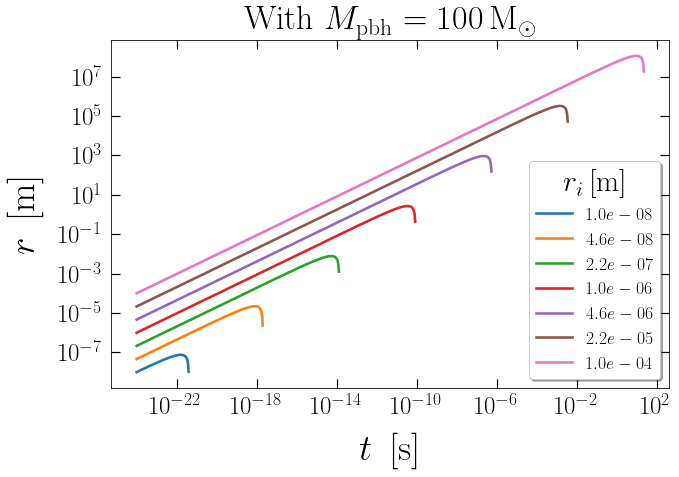

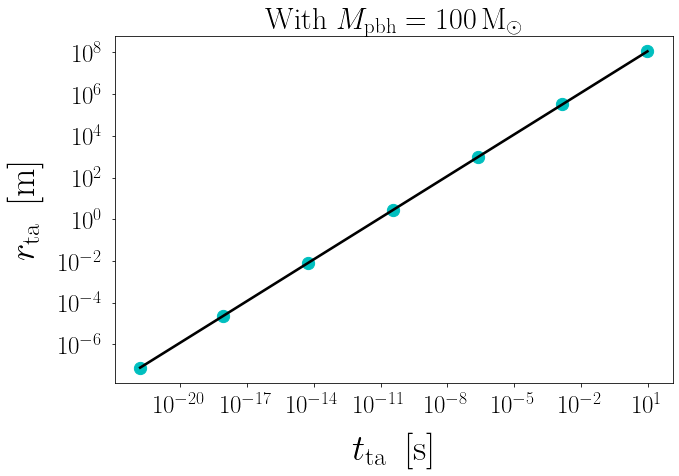

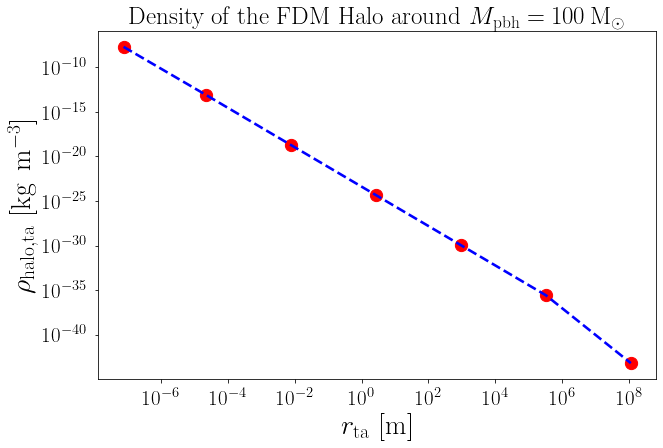

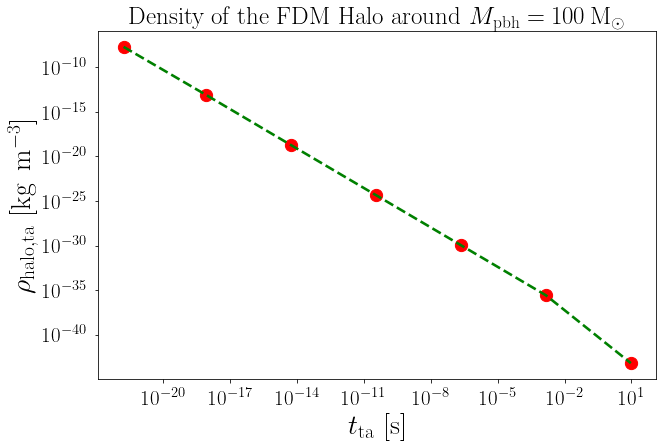

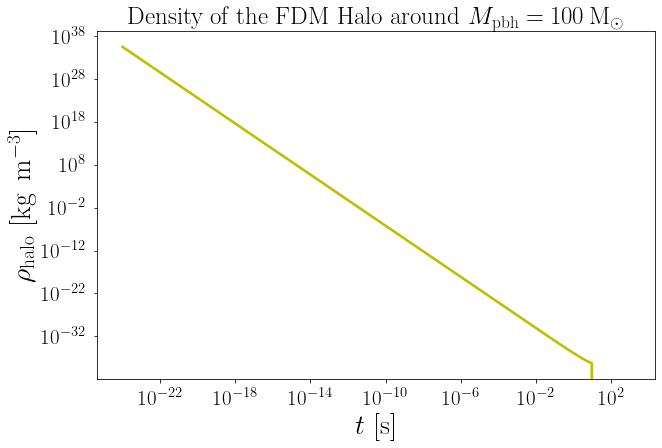

In [15]:
# Solving the shells simultaneously.


M_pbh = 100 * M_solar 
t_i = 1e-24
t_f = 1e3
r_min, r_max = 1e-8, 1e-4 
N = 7
ri_arr = np.geomspace(r_min, r_max, N)
t_arr = np.geomspace(t_i, t_f, 1000)  
dt = np.gradient(t_arr)

V_arr = (4 / 3) * np.pi * (ri_arr**3)
r_sol = np.zeros((N, len(t_arr)))  
v_sol = np.zeros((N, len(t_arr)))  
r_sol[:, 0] = ri_arr  
v_sol[:, 0] = ri_arr / (2 * t_i)  

turnaround_detected = np.zeros(N, dtype=bool)
t_ta_arr = np.zeros(N)  
r_ta_arr = np.zeros(N) 

for i in range(len(t_arr) - 1):
    t = t_arr[i]
    dt_i = dt[i]
    rho_arr = np.zeros(N - 1)
    delta_M_arr = np.zeros(N)
    for j in range(N - 1):
        delta_M_arr[j] = delta_M_dynamic(j, t)
        rho_arr[j] = delta_M_arr[j] / V_arr[j]

    QP_arr = QP_function(rho_arr, ri_arr)
    for j in range(N):
        M_enclosed = M_pbh #+ np.sum(delta_M_arr[:j])  
        dv_G_dt = -(G * M_enclosed) / (r_sol[j, i] ** 2) if r_sol[j, i] > 0 else 0
        dv_QP_dt = QP_arr[j-1] if j > 0 else 0  
        H_t = 1 / (2 * t)  
        dv_H_dt = -(H_t * v_sol[j, i])  
        dv_dt = dv_G_dt + dv_QP_dt + dv_H_dt  

        v_sol[j, i+1] = v_sol[j, i] + dv_dt * dt_i  
        r_sol[j, i+1] = r_sol[j, i] + v_sol[j, i] * dt_i
        if not turnaround_detected[j]: 
            if v_sol[j, i] > 0 and v_sol[j, i+1] < 0:
                turnaround_detected[j] = True
                t_ta_arr[j] = t_arr[i+1]
                r_ta_arr[j] = r_sol[j, i+1]
        elif t_arr[i] >= t_ta_arr[j]:  
            if i + 1 < len(t_arr):
                v_sol[j, i+1] = v_sol[j, i] + dv_dt * dt_i  
                r_sol[j, i+1] = r_sol[j, i] + v_sol[j, i] * dt_i


                
                
fig, ax1 = plt.subplots(figsize=(10, 6.4))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


turnaround_margin = 14  
for j in range(N):  
    turnaround_index = np.argmax(t_arr >= t_ta_arr[j]) 
    after_turnaround_index = min(turnaround_index + turnaround_margin, len(t_arr) - 1)
    ax1.loglog(t_arr[:after_turnaround_index+1], r_sol[j, :after_turnaround_index+1], label=f"${ri_arr[j]:.1e}$", color=colors[j % len(colors)])
ax1.tick_params(axis='x', pad=7.9)
ax1.tick_params(axis='y', pad=7.9)
plt.xlabel('$t \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r\,$ [m]',fontsize= 37, labelpad = 15)
plt.legend(prop = {'size':17.8}, loc = 'lower right',
           shadow = True, title = '$r_{i} \, [\mathrm{m}]$' ,title_fontsize = 30,
           facecolor = 'white',fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 34, pad = 8)
plt.savefig('fdmshells3.pdf', bbox_inches = 'tight')
plt.show()




#turnaround radius vs turnaround time
fig, ax2 = plt.subplots(figsize=(10, 6.4))
ax2.scatter(t_ta_arr, r_ta_arr, color="c", s=150)
ax2.loglog(t_ta_arr, r_ta_arr, "k")
ax2.tick_params(axis='x', pad=7.9)
ax2.tick_params(axis='y', pad=7.9)
plt.xlabel('$t_\mathrm{ta} \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r_\mathrm{ta}\,$ [m]',fontsize= 37, labelpad = 15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 30, pad = 8)
plt.savefig('rta_vs_t.pdf', bbox_inches = 'tight')
plt.show()





rho_halo_ta_arr = np.zeros(N)
for j in range(N):
    M_enclosed_at_rta =  np.sum(delta_M_arr[:j+1])  
    V_total_at_rta = ((4/3) * np.pi * (r_ta_arr[j]**3))
    rho_halo_ta_arr[j] = M_enclosed_at_rta/V_total_at_rta  if V_total_at_rta > 0 else 0

    



fig, ax3 = plt.subplots(figsize=(10, 6.4))
ax3.scatter(r_ta_arr, rho_halo_ta_arr, color="r", s=150)
ax3.loglog(r_ta_arr, rho_halo_ta_arr, "b", linestyle='--')
ax3.tick_params(axis='x', pad=7.9)
ax3.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$r_\mathrm{ta}$ [m]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo, ta}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_rta.pdf', bbox_inches = 'tight')
plt.show()



fig, ax4 = plt.subplots(figsize=(10, 6.4))
ax4.scatter(t_ta_arr, rho_halo_ta_arr, color="r", s=150)
ax4.loglog(t_ta_arr, rho_halo_ta_arr, "g", linestyle='--')
ax4.tick_params(axis='x', pad=7.9)
ax4.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t_\mathrm{ta}$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo, ta}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_tta.pdf', bbox_inches = 'tight')
plt.show()





rho_halo_arr = np.zeros(len(t_arr))
for i in range(len(t_arr)):
    M_total = 0
    max_r_ta = 0  
    for j in range(N):
        if t_arr[i] <= t_ta_arr[j]:
            m_shell = delta_M_dynamic(j, t_arr[i])
            max_r_ta = max(max_r_ta, r_sol[j, i])  
            M_total += m_shell
    V_total = ((4/3) * np.pi * (max_r_ta**3))  
    if V_total > 0:
        rho_halo_arr[i] = M_total/V_total
    else:
        rho_halo_arr[i] = 0


    
#total density of the FDM halo as a function of time, t
fig, ax5 = plt.subplots(figsize=(10, 6.4))
ax5.loglog(t_arr, rho_halo_arr,  color='y')
ax5.tick_params(axis='x', pad=7.9)
ax5.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_t.pdf', bbox_inches = 'tight')
plt.show()






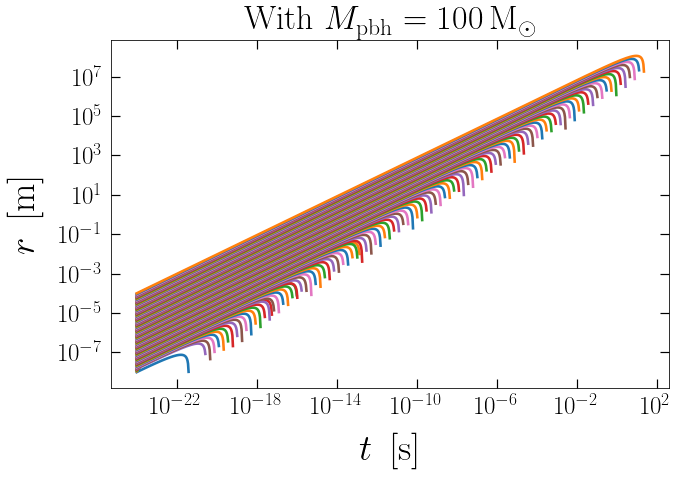

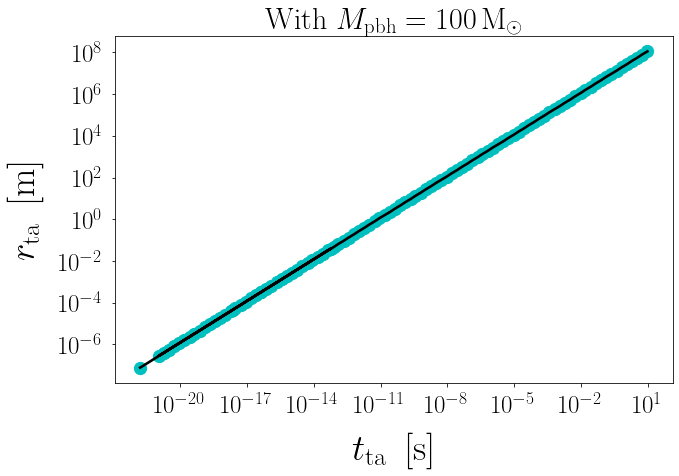

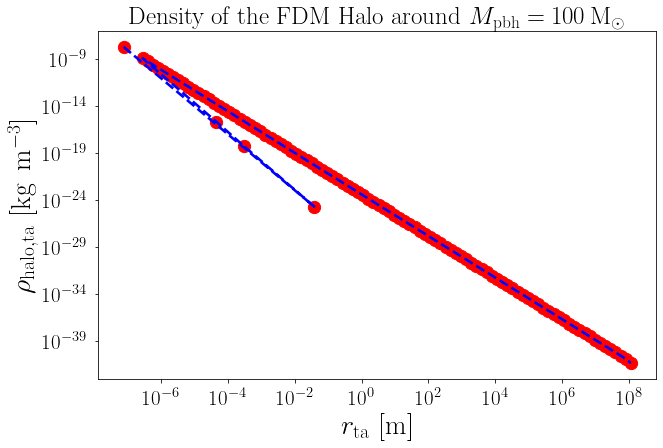

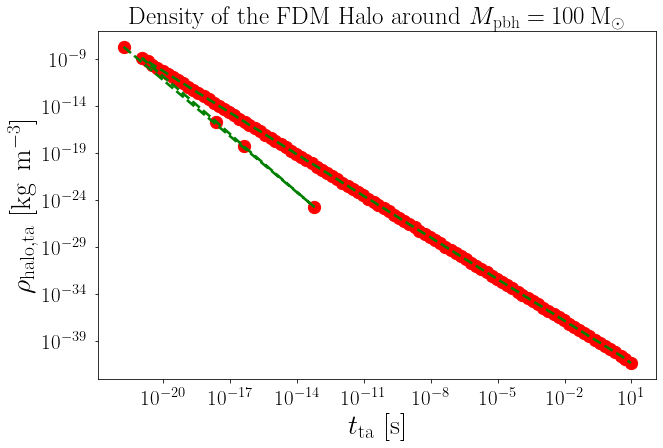

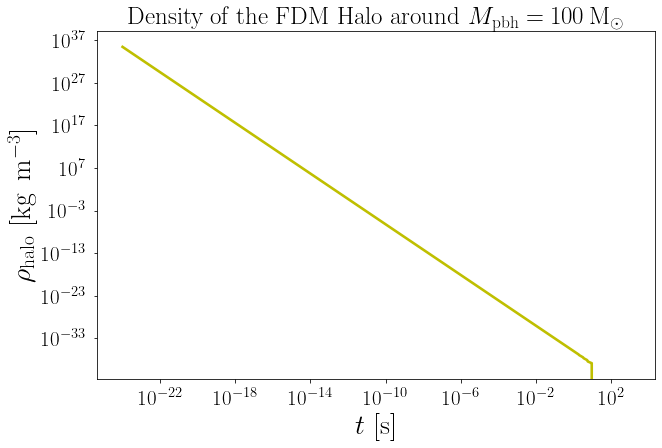

In [24]:
# Solving the shells simultaneously.


M_pbh = 100 * M_solar 
t_i = 1e-24
t_f = 1e3
r_min, r_max = 1e-8, 1e-4 
N = 100
ri_arr = np.geomspace(r_min, r_max, N)
t_arr = np.geomspace(t_i, t_f, 1000)  
dt = np.gradient(t_arr)

V_arr = (4 / 3) * np.pi * (ri_arr**3)
r_sol = np.zeros((N, len(t_arr)))  
v_sol = np.zeros((N, len(t_arr)))  
r_sol[:, 0] = ri_arr  
v_sol[:, 0] = ri_arr / (2 * t_i)  

turnaround_detected = np.zeros(N, dtype=bool)
t_ta_arr = np.zeros(N)  
r_ta_arr = np.zeros(N) 

for i in range(len(t_arr) - 1):
    t = t_arr[i]
    dt_i = dt[i]
    rho_arr = np.zeros(N - 1)
    delta_M_arr = np.zeros(N)
    for j in range(N - 1):
        delta_M_arr[j] = delta_M_dynamic(j, t)
        rho_arr[j] = delta_M_arr[j] / V_arr[j]

    QP_arr = QP_function(rho_arr, ri_arr)
    for j in range(N):
        M_enclosed = M_pbh #+ np.sum(delta_M_arr[:j])  
        dv_G_dt = -(G * M_enclosed) / (r_sol[j, i] ** 2) if r_sol[j, i] > 0 else 0
        dv_QP_dt = QP_arr[j-1] if j > 0 else 0  
        H_t = 1 / (2 * t)  
        dv_H_dt = -(H_t * v_sol[j, i])  
        dv_dt = dv_G_dt + dv_QP_dt + dv_H_dt  

        v_sol[j, i+1] = v_sol[j, i] + dv_dt * dt_i  
        r_sol[j, i+1] = r_sol[j, i] + v_sol[j, i] * dt_i
        if not turnaround_detected[j]: 
            if v_sol[j, i] > 0 and v_sol[j, i+1] < 0:
                turnaround_detected[j] = True
                t_ta_arr[j] = t_arr[i+1]
                r_ta_arr[j] = r_sol[j, i+1]
        elif t_arr[i] >= t_ta_arr[j]:  
            if i + 1 < len(t_arr):
                v_sol[j, i+1] = v_sol[j, i] + dv_dt * dt_i  
                r_sol[j, i+1] = r_sol[j, i] + v_sol[j, i] * dt_i


                
                
fig, ax1 = plt.subplots(figsize=(10, 6.4))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


turnaround_margin = 14  
for j in range(N):  
    turnaround_index = np.argmax(t_arr >= t_ta_arr[j]) 
    after_turnaround_index = min(turnaround_index + turnaround_margin, len(t_arr) - 1)
    ax1.loglog(t_arr[:after_turnaround_index+1], r_sol[j, :after_turnaround_index+1], label=f"${ri_arr[j]:.1e}$", color=colors[j % len(colors)])
ax1.tick_params(axis='x', pad=7.9)
ax1.tick_params(axis='y', pad=7.9)
plt.xlabel('$t \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r\,$ [m]',fontsize= 37, labelpad = 15)
#plt.legend(prop = {'size':17.8}, loc = 'lower right', shadow = True, title = '$r_{i} \, [\mathrm{m}]$' ,title_fontsize = 30,
           # facecolor = 'white',fontsize = 28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 34, pad = 8)
plt.savefig('fdmshells3.pdf', bbox_inches = 'tight')
plt.show()




#turnaround radius vs turnaround time
fig, ax2 = plt.subplots(figsize=(10, 6.4))
ax2.scatter(t_ta_arr, r_ta_arr, color="c", s=150)
ax2.loglog(t_ta_arr, r_ta_arr, "k")
ax2.tick_params(axis='x', pad=7.9)
ax2.tick_params(axis='y', pad=7.9)
plt.xlabel('$t_\mathrm{ta} \,$ [s]',fontsize= 37, labelpad = 15)
plt.ylabel('$r_\mathrm{ta}\,$ [m]',fontsize= 37, labelpad = 15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('With $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize = 30, pad = 8)
plt.savefig('rta_vs_t.pdf', bbox_inches = 'tight')
plt.show()





rho_halo_ta_arr = np.zeros(N)
for j in range(N):
    M_enclosed_at_rta =  np.sum(delta_M_arr[:j+1])  
    V_total_at_rta = ((4/3) * np.pi * (r_ta_arr[j]**3))
    rho_halo_ta_arr[j] = M_enclosed_at_rta/V_total_at_rta  if V_total_at_rta > 0 else 0

    



fig, ax3 = plt.subplots(figsize=(10, 6.4))
ax3.scatter(r_ta_arr, rho_halo_ta_arr, color="r", s=150)
ax3.loglog(r_ta_arr, rho_halo_ta_arr, "b", linestyle='--')
ax3.tick_params(axis='x', pad=7.9)
ax3.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$r_\mathrm{ta}$ [m]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo, ta}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_rta.pdf', bbox_inches = 'tight')
plt.show()



fig, ax4 = plt.subplots(figsize=(10, 6.4))
ax4.scatter(t_ta_arr, rho_halo_ta_arr, color="r", s=150)
ax4.loglog(t_ta_arr, rho_halo_ta_arr, "g", linestyle='--')
ax4.tick_params(axis='x', pad=7.9)
ax4.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t_\mathrm{ta}$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo, ta}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_tta.pdf', bbox_inches = 'tight')
plt.show()





rho_halo_arr = np.zeros(len(t_arr))
for i in range(len(t_arr)):
    M_total = 0
    max_r_ta = 0  
    for j in range(N):
        if t_arr[i] <= t_ta_arr[j]:
            m_shell = delta_M_dynamic(j, t_arr[i])
            max_r_ta = max(max_r_ta, r_sol[j, i])  
            M_total += m_shell
    V_total = ((4/3) * np.pi * (max_r_ta**3))  
    if V_total > 0:
        rho_halo_arr[i] = M_total/V_total
    else:
        rho_halo_arr[i] = 0


    
#total density of the FDM halo as a function of time, t
fig, ax5 = plt.subplots(figsize=(10, 6.4))
ax5.loglog(t_arr, rho_halo_arr,  color='y')
ax5.tick_params(axis='x', pad=7.9)
ax5.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_t.pdf', bbox_inches = 'tight')
plt.show()




